# This notebook shows ClusterBuster and Homer experiments.
#### It uses contribution scores and TFModisco scores generated in the MM_EFS_TFModisco notebook.
#### The motif database file is provided in ./data/tomtom folder
#### It consists of:
* Getting TFModisco patterns and saving as txt file to be later used by ClusterBuster.
* Running Tomtom on TFModisco patterns.
* Running ClusterBuster by using TFModisco pattern PWMs on the sequences generated by in silico evolution, motif implantation, and GAN.
* Running Homer using Random and Evolved sequences as foreground and background sequences, and vice versa.
#### ClusterBuster results are in ./data/cbust folder.
#### Homer results are in ./data/homer folder.
#### Figures are saved to ./figures/cbust folder

### General imports


In [9]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import pandas as pd
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### Loading the contribution scores calculated in the MM_EFS_TFModisco script

In [10]:
tasks = {}
task_to_scores = {}
task_to_hyp_scores = {}
onehot_data = {}
for i in [4]:
    f = open("data/tfmodisco/MMEFS_M4_topic16_shapvalues.pkl", "rb")
    tasks[i] = pickle.load(f)
    task_to_scores[i] = pickle.load(f)
    task_to_hyp_scores[i] = pickle.load(f)
    onehot_data[i] = pickle.load(f)
    f.close()

### Loading the TFModisco results calculated in the MM_EFS_TFModisco script
### Trimming the identified patterns and saving them as text and =.cb files to be used by ClusterBuster and TOMTOM

In [2]:
# From TFModisco
# def get_ic_trimming_indices(ppm, background, threshold, pseudocount=0.001):
#     """Return tuple of indices to trim to if ppm is trimmed by info content.
#     The ppm will be trimmed from the left and from the right until a position
#      that meets the information content specified by threshold is found. A
#      base of 2 is used for the infromation content.
#     Arguments:
#         threshold: the minimum information content.
#         remaining arguments same as for compute_per_position_ic
#     Returns:
#         (start_idx, end_idx). start_idx is inclusive, end_idx is exclusive.
#     """
#     per_position_ic = compute_per_position_ic(
#                        ppm=ppm, background=background, pseudocount=pseudocount)
#     passing_positions = np.where(per_position_ic >= threshold)
#     return (passing_positions[0][0], passing_positions[0][-1]+1)

# def compute_per_position_ic(ppm, background, pseudocount):
#     """Compute information content at each position of ppm.
#     Arguments:
#         ppm: should have dimensions of length x alphabet. Entries along the
#             alphabet axis should sum to 1.
#         background: the background base frequencies
#         pseudocount: pseudocount to be added to the probabilities of the ppm
#             to prevent overflow/underflow.
#     Returns:
#         total information content at each positon of the ppm.
#     """
#     assert len(ppm.shape)==2
#     assert ppm.shape[1]==len(background),\
#             "Make sure the letter axis is the second axis"
#     assert (np.max(np.abs(np.sum(ppm, axis=1)-1.0)) < 1e-7),(
#              "Probabilities don't sum to 1 along axis 1 in "
#              +str(ppm)+"\n"+str(np.sum(ppm, axis=1)))
#     alphabet_len = len(background)
#     ic = ((np.log((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/np.log(2))
#           *ppm - (np.log(background)*background/np.log(2))[None,:])
#     return np.sum(ic,axis=1)

# import h5py
# hdf5_results = h5py.File("data/tfmodisco/MMEFS_M4_results.hdf5","r")

# metacluster_names = [x.decode("utf-8") for x in list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])]

# n_mut = 4
# motif_dict = {}
# with open("data/tfmodisco/selected_patterns.txt", 'w') as fw_pattern:
#     for metacluster_name in metacluster_names:
#         motif_dict[metacluster_name] = {}
#         metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"][metacluster_name])
#         pattern_names = [x.decode("utf-8") for x in list(metacluster_grp["seqlets_to_patterns_result"]["patterns"]["all_pattern_names"][:])]

#         background = np.mean(onehot_data[n_mut], axis=(0,1))
#         for pattern_name in pattern_names:
#             pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
#             pattern_array = np.array(pattern["sequence"]["fwd"])
#             start, end = get_ic_trimming_indices(pattern_array, background=np.mean(onehot_data[n_mut], axis=(0,1)), threshold=0.1)
#             # Motif(pattern_array).plot_logo()
#             # Motif(pattern_array[start:end,:]).plot_logo()
#             #motif_dict[metacluster_name][pattern_name] = Motif(np.array(pattern["sequence"]["fwd"])).trim(0.1)

#             print(f'{metacluster_name}_{pattern_name}',file=fw_pattern)

#             with open(f'data/cbust/EFS_M4_motifs/MMFS_M{n_mut}_{metacluster_name}_{pattern_name}.cb', 'w') as fw:
#                 print(f'>{metacluster_name}_{pattern_name}',file=fw)
#                 for i in pattern_array[start:end,:]*100:
#                     print(*i,file=fw)

# n_mut = 4
# background = np.mean(onehot_data[n_mut], axis=(0,1))
# with open("data/tomtom/EFS_M4_motifs.txt", 'w') as fw_pattern:
#     for metacluster_name in metacluster_names:
#         metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"][metacluster_name])
#         pattern_names = [x.decode("utf-8") for x in list(metacluster_grp["seqlets_to_patterns_result"]["patterns"]["all_pattern_names"][:])]

#         for pattern_name in pattern_names:
#             pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
#             pattern_array = np.array(pattern["sequence"]["fwd"])
#             start, end = get_ic_trimming_indices(pattern_array, background=background, threshold=0.1)
    
#             print(' ',file=fw_pattern)
#             for i in pattern_array[start:end,:]:
#                 print(*i,file=fw_pattern, sep='\t')


# hdf5_results.close()

### Running TOMTOM on the TFModisco patterns

In [29]:
%%bash
cd ./data/tomtom/

module load cluster/wice/bigmem
module load MEME/5.5.1-GCC-10.3.0

LC_ALL=en_US.utf8 ls motif-*.meme | parallel -j 12 --plus '
sampleName="{/.}"
echo $sampleName
tomtom -thresh 0.3 \
        -oc ./$sampleName \
        $sampleName.meme \
        ./motif2gene_names.all.meme
'

LC_ALL=en_US.utf8 ls motif-4*.meme | parallel -j 12 --plus '
sampleName="{/.}"
echo $sampleName
tomtom -thresh 1 \
        -oc ./$sampleName \
        $sampleName.meme \
        ./motif2gene_names.all.meme
'

motif-4
motif-3
motif-2
motif-1
motif-4



The following have been reloaded with a version change:
  1) cluster/wice/dedicated_big_gpu => cluster/wice/bigmem

The output directory './motif-4' already exists.
Its contents will be overwritten.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00151
#   Estimated pi_0=1
The output directory './motif-3' already exists.
Its contents will be overwritten.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996969
#   Estimated pi_0=0.996969
The output directory './motif-2' already exists.
Its contents will be overwritten.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97176
#   Estimated pi_0=0.973172
The output directory './motif-1' already exists.
Its contents will be overwritten.
Processing 

### Printing synthetic sequences (generated via in silico evolution) as fasta file for different mutational steps

In [3]:
# import pickle
# f = open("data/deepmel2/MM_EFS_4000_withmut.pkl", "rb")
# evolved_seq_4000_dict = pickle.load(f)
# f.close()

# for n_mut in range(16):
#     with open(f'data/cbust/EFS_fasta/MMEFS_M{n_mut}.fa','w') as fw:
#         for id_ in range(len(evolved_seq_4000_dict["X"])):
#             start_x = np.copy(evolved_seq_4000_dict["X"][id_:id_+1])
#             for i, mut_ in enumerate(evolved_seq_4000_dict["mut_loc"][id_][:n_mut]):
#                 #print(i,end=",")
#                 start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')   
#             print(f'>{id_}', file=fw)
#             for nuc in start_x[0]:
#                 if nuc[0]==1:
#                     print("A",end="", file=fw)
#                 if nuc[1]==1:
#                     print("C",end="", file=fw)
#                 if nuc[2]==1:
#                     print("G",end="", file=fw)
#                 if nuc[3]==1:
#                     print("T",end="", file=fw)
#             print("", file=fw)

### Running ClusterBuster on synthetic (generated via in silico evolution), Genomic, GAN-generated, and background sequences using the motifs identified by TFModisco

In [4]:
# %%bash

# fasta_folder=data/cbust/EFS_fasta
# folder=data/cbust/EFS_M4_results
# matrix_prefix=data/cbust/EFS_M4_motifs/MMEFS_M4_

# module load Cluster-Buster/20220421-GCC-11.3.0
# for i in {0..15}
# do
#     echo seq_M${i}
#     cd ${folder}
#     mkdir seq_M${i}

#     while read -r line
#     do
#     matrix_file=${matrix_prefix}${line}.cb
#     cbust -c 0 -m 3 -f 5 ${matrix_file} ${fasta_folder}/MMEFS_M${i}.fa > ${folder}/seq_M${i}/MMEFS_M${i}.${line}.bed
#     done < selected_patterns.txt
#     cat ${folder}/seq_M${i}/MMEFS_M${i}.*.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 > ${folder}/seq_M${i}/MMEFS_M${i}.selected.motif.gff
# done

# module load BEDTools/2.30.0-GCC-10.3.0
# for i in {0..15}
# do
#     echo seq_M${i}
#     cd ${folder}

#     while read -r line
#     do
#     cat ${folder}/seq_M${i}/MMEFS_M${i}.${line}.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 | sort -k1,1 -k2,2n  > ${folder}/seq_M${i}/MMEFS_M${i}.${line}.motif.bed
#     bedtools merge -c 4,5 -o first,max -d -4 -i ${folder}/seq_M${i}/MMEFS_M${i}.${line}.motif.bed > ${folder}/seq_M${i}/MMEFS_M${i}.${line}.motif.merged.bed
#     done < selected_patterns.txt
#     cat ${folder}/seq_M${i}/MMEFS_M${i}.*.motif.merged.bed > ${folder}/seq_M${i}/MMEFS_M${i}.selected.motif.merged.gff
# done

In [5]:
# def gff_to_npz_as_array(filename):
#     with open(filename) as file:
#         result = []
#         for line in file:
#             if line.startswith("#"):
#                 continue
#             tabs = line.strip().split('\t')
#             seq_name = int(tabs[0])
#             start = int(tabs[1])
#             end = int(tabs[2])
#             motif_name = tabs[3]
#             metacluster_name = int(motif_name.split('_')[1])
#             pattern_name = int(motif_name.split('_')[3])
#             score = float(tabs[4])
#             # strand = 0 if tabs[5]=='-' else 1
#             result.append([seq_name, metacluster_name, pattern_name, start, end, score,])# strand])  
#     return np.array(result)

# cbust_mot_array_merged = {}
# for n_mut in range(16):
#     gff_filename = f'data/cbust/EFS_M4_results/seq_M{n_mut}/MMEFS_M{n_mut}.selected.motif.merged.gff'
#     cbust_mot_array_merged[n_mut] = gff_to_npz_as_array(gff_filename) 
    
# import pickle
# f = open("data/cbust/EFS_M4_results/EFS_cbust_mot_array_merged.pkl", "wb")
# pickle.dump(cbust_mot_array_merged, f)
# f.close()

In [6]:
# %%bash
# module load BEDTools/2.30.0-GCC-10.3.0
# module load Cluster-Buster/20220421-GCC-11.3.0


# folder=data/cbust/EFS_M4_results
# matrix_prefix=data/cbust/EFS_M4_motifs/MMFS_M4_
# MEL_fasta=data/deepmel2/Genomic_MEL_regions.fa

# cd ${folder}

# while read -r line
# do
# matrix_file=${matrix_prefix}${line}.cb
# cbust -c 0 -m 3 -f 5 ${matrix_file} ${MEL_fasta} > ${folder}/genomic/MEL_genomic.${line}.bed
# cat ${folder}/genomic/MEL_genomic.${line}.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 | sort -k1,1 -k2,2n  > ${folder}/genomic/MEL_genomic.${line}.motif.bed
# bedtools merge -c 4,5 -o first,max -d -4 -i ${folder}/genomic/MEL_genomic.${line}.motif.bed > ${folder}/genomic/MEL_genomic.${line}.motif.merged.bed
# done < selected_patterns.txt
# cat ${folder}/genomic/MEL_genomic.*.motif.merged.bed > ${folder}/genomic/MEL_genomic.selected.motif.merged.gff

In [7]:
# import pandas as pd
# def gff_to_npz_as_pandas(filename):
#     with open(filename) as file:
#         result = []
#         for line in file:
#             if line.startswith("#"):
#                 continue
#             tabs = line.strip().split('\t')
#             seq_name = tabs[0]
#             start = int(tabs[1])
#             end = int(tabs[2])
#             motif_name = tabs[3]
#             metacluster_name = int(motif_name.split('_')[1])
#             pattern_name = int(motif_name.split('_')[3])
#             score = float(tabs[4])
#             # strand = 0 if tabs[5]=='-' else 1
#             result.append([seq_name, metacluster_name, pattern_name, start, end, score,])# strand])  
#     return pd.DataFrame(result, columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score", ])#"strand"])

# gff_filename = '=data/cbust/EFS_M4_results/genomic/MEL_genomic.selected.motif.merged.gff'
# cbust_mot_array_genomic = gff_to_npz_as_pandas(gff_filename) 

# import pickle
# f = open("data/cbust/EFS_M4_results/Genomic_cbust_mot_array_merged.pkl", "wb")
# pickle.dump(cbust_mot_array_genomic, f)
# f.close()

In [8]:
# import pickle 
# with open('data/gan/GAN_data_dict.pkl', 'rb') as f:
#     GAN_data_dict = pickle.load(f)
    
# for iter_ in GAN_data_dict['MMgan']:
#     with open(f'data/cbust/GAN_fasta/MMGAN_I{iter_}.fa','w') as fw:
#         for seq in range(len(GAN_data_dict['MMgan'][iter_]['seq'])):
#             print(f'>{seq}', file=fw)
#             for nuc in GAN_data_dict['MMgan'][iter_]['seq'][seq]:
#                 if nuc[0]==1:
#                     print("A",end="", file=fw)
#                 if nuc[1]==1:
#                     print("C",end="", file=fw)
#                 if nuc[2]==1:
#                     print("G",end="", file=fw)
#                 if nuc[3]==1:
#                     print("T",end="", file=fw)
#             print("", file=fw)

# for iter_ in GAN_data_dict['bg']:
#     with open(f'data/cbust/BG_fasta/bg_I{iter_}.fa','w') as fw:
#         for seq in range(len(GAN_data_dict['bg'][iter_]['seq'])):
#             print(f'>{seq}', file=fw)
#             for nuc in GAN_data_dict['bg'][iter_]['seq'][seq]:
#                 if nuc[0]==1:
#                     print("A",end="", file=fw)
#                 if nuc[1]==1:
#                     print("C",end="", file=fw)
#                 if nuc[2]==1:
#                     print("G",end="", file=fw)
#                 if nuc[3]==1:
#                     print("T",end="", file=fw)
#             print("", file=fw)

In [9]:
# %%bash
# module load BEDTools/2.30.0-GCC-10.3.0
# module load Cluster-Buster/20220421-GCC-11.3.0

# for i in $(seq 0 10000 160000)
# do
#     echo seq_I${i}
#     fasta_folder=data/cbust/GAN_fasta
#     folder=data/cbust/GAN_M4_results
#     matrix_prefix=data/cbust/EFS_M4_motifs/MMFS_M4_
#     cd ${folder}
#     mkdir seq_I${i}

#     while read -r line
#     do
#         matrix_file=${matrix_prefix}${line}.cb
#         cbust -c 0 -m 3 -f 5 ${matrix_file} ${fasta_folder}/MMGAN_I${i}.fa > ${folder}/seq_I${i}/MMGAN_I${i}.${line}.bed
#         cat ${folder}/seq_I${i}/MMGAN_I${i}.${line}.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 | sort -k1,1 -k2,2n  > ${folder}/seq_I${i}/MMGAN_I${i}.${line}.motif.bed
#         bedtools merge -c 4,5 -o first,max -d -4 -i ${folder}/seq_I${i}/MMGAN_I${i}.${line}.motif.bed > ${folder}/seq_I${i}/MMGAN_I${i}.${line}.motif.merged.bed
#     done < selected_patterns.txt
#     cat ${folder}/seq_I${i}/MMGAN_I${i}.*.motif.merged.bed > ${folder}/seq_I${i}/MMGAN_I${i}.selected.motif.merged.gff
# done


# for i in $(seq 0 1 4)
# do
#     echo seq_I${i}
#     fasta_folder=data/cbust/BG_fasta
#     folder=data/cbust/BG_M4_results
#     matrix_prefix=data/cbust/EFS_M4_motifs/MMFS_M4_
#     cd ${folder}
#     mkdir seq_I${i}

#     while read -r line
#     do
#         matrix_file=${matrix_prefix}${line}.cb
#         cbust -c 0 -m 3 -f 5 ${matrix_file} ${fasta_folder}/bg_I${i}.fa > ${folder}/seq_I${i}/bg_I${i}.${line}.bed
#         cat ${folder}/seq_I${i}/bg_I${i}.${line}.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 | sort -k1,1 -k2,2n  > ${folder}/seq_I${i}/bg_I${i}.${line}.motif.bed
#         bedtools merge -c 4,5 -o first,max -d -4 -i ${folder}/seq_I${i}/bg_I${i}.${line}.motif.bed > ${folder}/seq_I${i}/bg_I${i}.${line}.motif.merged.bed
#     done < selected_patterns.txt
#     cat ${folder}/seq_I${i}/bg_I${i}.*.motif.merged.bed > ${folder}/seq_I${i}/bg_I${i}.selected.motif.merged.gff
# done

In [10]:
# cbust_mot_array_GAN = {}
# for n_mut in GAN_data_dict['MMgan']:
#     gff_filename = f'data/cbust/GAN_M4_results/seq_I{n_mut}/MMGAN_I{n_mut}.selected.motif.merged.gff'
#     cbust_mot_array_GAN[n_mut] = gff_to_npz_as_array(gff_filename) 

# import pickle
# f = open("data/cbust/GAN_M4_results/GAN_cbust_mot_array_merged.pkl", "wb")
# pickle.dump(cbust_mot_array_GAN, f)
# f.close()


# cbust_mot_array_bg = {}
# for n_mut in GAN_data_dict['bg']:
#     gff_filename = f'data/cbust/BG_M4_results/seq_I{n_mut}/bg_I{n_mut}.selected.motif.merged.gff'
#     cbust_mot_array_bg[n_mut] = gff_to_npz_as_array(gff_filename) 

# import pickle
# f = open("data/cbust/BG_M4_results/BG_cbust_mot_array_merged.pkl", "wb")
# pickle.dump(cbust_mot_array_bg, f)
# f.close()

In [11]:
import pickle
f = open("data/cbust/EFS_M4_results/EFS_cbust_mot_array_merged.pkl", "rb")
EFS_cbust_mot_array_merged = pickle.load(f)
f.close()

import pickle
f = open("data/cbust/EFS_M4_results/Genomic_cbust_mot_array_merged.pkl", "rb")
Genomic_cbust_mot_array_merged = pickle.load(f)
f.close()

import pickle
f = open("data/cbust/GAN_M4_results/GAN_cbust_mot_array_merged.pkl", "rb")
GAN_cbust_mot_array_merged = pickle.load(f)
f.close()

import pickle
f = open("data/cbust/BG_M4_results/BG_cbust_mot_array_merged.pkl", "rb")
BG_cbust_mot_array_merged = pickle.load(f)
f.close()

In [12]:
#EFS #4000
#Genomic #3885
#GAN #3968
#BG #3968

### Plotting the motif enrichment results at different mutational steps

SOX10 threshold: 5.983922503108955
MITF threshold: 5.627510330271076
TFAP2 threshold: 5.691823528631348
ZEB2 threshold: 5.90920590448853


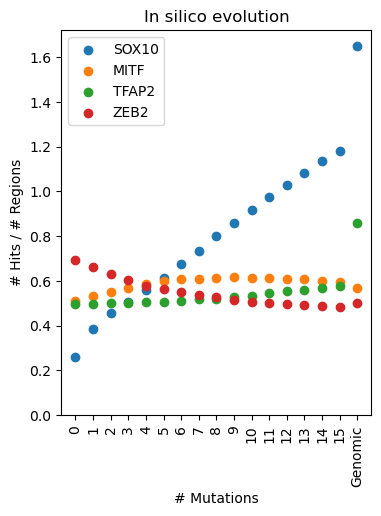

In [13]:
plt.figure(figsize=(4,5))
for i, [metacluster_name, pattern_name, TF_name] in enumerate([[0,3,"SOX10"],[0,4,"MITF"],[0,9,"TFAP2"],[1,0,"ZEB2"]]):
    data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
    th_ = np.mean(data_)+1*np.std(data_)
    print(f'{TF_name} threshold: {th_}')
    ratios = []
    for n_mut in range(16):
        data_ = np.sum(EFS_cbust_mot_array_merged[n_mut][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[n_mut][:,1]==metacluster_name,EFS_cbust_mot_array_merged[n_mut][:,2]==pattern_name))]>th_)
        ratios.append(data_/4000)
        plt.scatter(n_mut,data_/4000,color=f'C{i}')
    data_ = np.sum(Genomic_cbust_mot_array_merged['score'][(Genomic_cbust_mot_array_merged['metacluster_name'] == metacluster_name) & (Genomic_cbust_mot_array_merged['pattern_name'] == pattern_name)]>th_)
    plt.scatter(16,data_/3885,color=f'C{i}',label=TF_name)
    ratios.append(data_/3885)
    _ = plt.ylim(bottom=0)
plt.ylabel("# Hits / # Regions")
plt.xlabel("# Mutations")
plt.title("In silico evolution")
plt.legend()
_ = plt.xticks(range(17),list(range(16))+["Genomic"],rotation=90)
plt.savefig("figures/cbust/EFS_motif.pdf",transparent=True)

### Plotting the motif enrichment results at different iterations of GAN

SOX10 threshold: 5.983922503108955
MITF threshold: 5.627510330271076
TFAP2 threshold: 5.691823528631348
ZEB2 threshold: 5.90920590448853


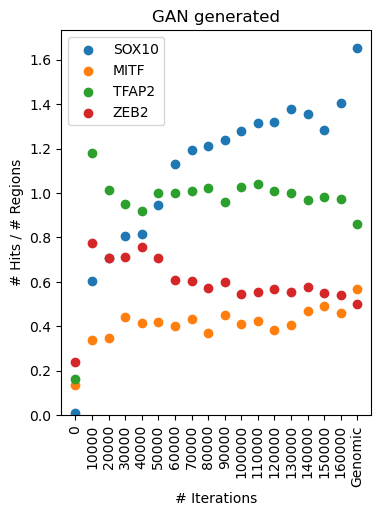

In [14]:
plt.figure(figsize=(4,5))
for i, [metacluster_name, pattern_name, TF_name] in enumerate([[0,3,"SOX10"],[0,4,"MITF"],[0,9,"TFAP2"],[1,0,"ZEB2"]]):
    data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
    th_ = np.mean(data_)+1*np.std(data_)
    print(f'{TF_name} threshold: {th_}')
    ratios = []
    for n_mut in GAN_cbust_mot_array_merged:
        data_ = np.sum(GAN_cbust_mot_array_merged[n_mut][:,5][np.logical_and.reduce((GAN_cbust_mot_array_merged[n_mut][:,1]==metacluster_name,GAN_cbust_mot_array_merged[n_mut][:,2]==pattern_name))]>th_)
        ratios.append(data_/3968)
        plt.scatter(n_mut,data_/3968,color=f'C{i}')
    data_ = np.sum(Genomic_cbust_mot_array_merged['score'][(Genomic_cbust_mot_array_merged['metacluster_name'] == metacluster_name) & (Genomic_cbust_mot_array_merged['pattern_name'] == pattern_name)]>th_)
    plt.scatter(170000,data_/3885,color=f'C{i}',label=TF_name)
    ratios.append(data_/3885)
    _ = plt.ylim(bottom=0)
plt.ylabel("# Hits / # Regions")
plt.xlabel("# Iterations")
plt.legend()
plt.title("GAN generated")
_ = plt.xticks(range(0,180000,10000),list(range(0,170000,10000))+["Genomic"],rotation=90)
plt.savefig("figures/cbust/GAN_motif.pdf",transparent=True)

### Plotting the motif enrichment results at different orders used to generate background sequences

SOX10 threshold: 5.983922503108955
MITF threshold: 5.627510330271076
TFAP2 threshold: 5.691823528631348
ZEB2 threshold: 5.90920590448853


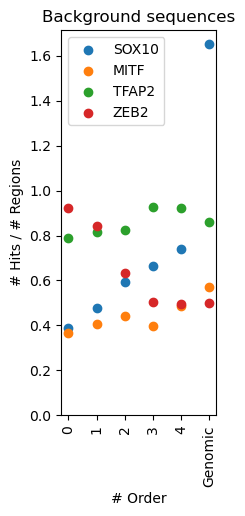

In [15]:
plt.figure(figsize=(2,5))
for i, [metacluster_name, pattern_name, TF_name] in enumerate([[0,3,"SOX10"],[0,4,"MITF"],[0,9,"TFAP2"],[1,0,"ZEB2"]]):
    data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
    th_ = np.mean(data_)+1*np.std(data_)
    print(f'{TF_name} threshold: {th_}')
    ratios = []
    for n_mut in BG_cbust_mot_array_merged:
        data_ = np.sum(BG_cbust_mot_array_merged[n_mut][:,5][np.logical_and.reduce((BG_cbust_mot_array_merged[n_mut][:,1]==metacluster_name,BG_cbust_mot_array_merged[n_mut][:,2]==pattern_name))]>th_)
        ratios.append(data_/3968)
        plt.scatter(n_mut,data_/3968,color=f'C{i}')
    data_ = np.sum(Genomic_cbust_mot_array_merged['score'][(Genomic_cbust_mot_array_merged['metacluster_name'] == metacluster_name) & (Genomic_cbust_mot_array_merged['pattern_name'] == pattern_name)]>th_)
    plt.scatter(5,data_/3885,color=f'C{i}',label=TF_name)
    ratios.append(data_/3885)
    _ = plt.ylim(bottom=0)
plt.ylabel("# Hits / # Regions")
plt.xlabel("# Order")
plt.title("Background sequences")
plt.legend()
_ = plt.xticks(range(6),list(range(5))+["Genomic"],rotation=90)
plt.savefig("figures/cbust/BG_motif.pdf",transparent=True)

### Plotting the delta motif enrichment results at different mutational steps

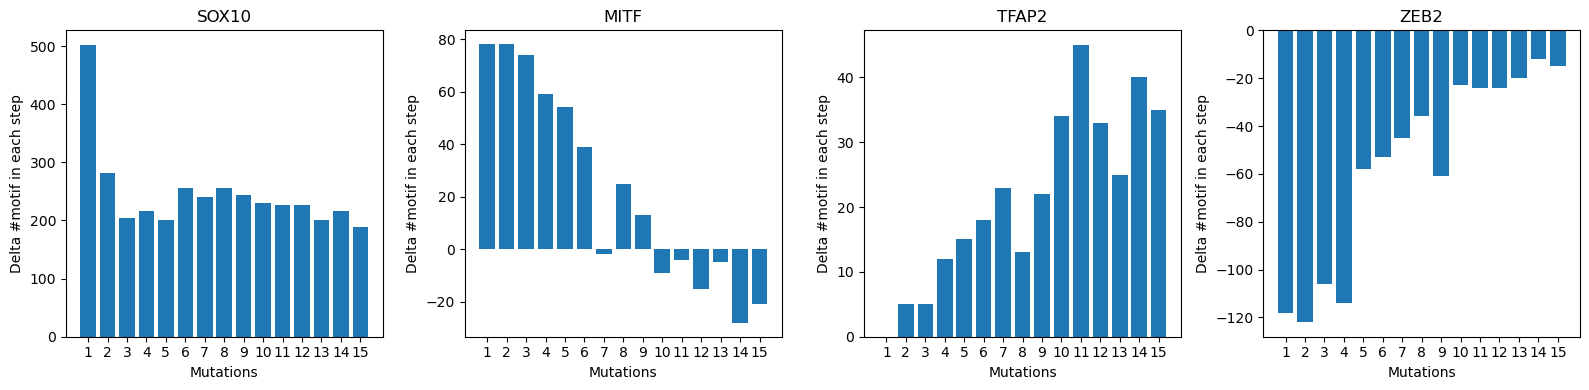

In [16]:
fig = plt.figure(figsize=(16,4))
for i, [metacluster_name, pattern_name, TF_name] in enumerate([[0,3,"SOX10"],[0,4,"MITF"],[0,9,"TFAP2"],[1,0,"ZEB2"]]): 
    ax = fig.add_subplot(1,4,i+1)
    x = []
    for n_mut in range(16):
        data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
        th_ = np.mean(data_)+1*np.std(data_)
        cbust_mot_data = pd.DataFrame(EFS_cbust_mot_array_merged[n_mut], columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score", ])#"strand"])
        x.append(len(cbust_mot_data[(cbust_mot_data['metacluster_name'] == metacluster_name) & 
                                             (cbust_mot_data['pattern_name'] == pattern_name) & 
                                             (cbust_mot_data['score'] >= th_)]))

    plt.bar(range(15),np.diff(x))
    plt.title(TF_name)
    plt.xlabel("Mutations")
    plt.ylabel("Delta #motif in each step")
    plt.xticks(range(15),list(range(1,16)))
fig.tight_layout()
plt.savefig("figures/cbust/EFS_delta_motif.pdf",transparent=True)

### Selecting the sequences to be tested

In [21]:
n_mut = 15
cbust_mot_data = pd.DataFrame(EFS_cbust_mot_array_merged[n_mut], columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score"])

data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==0,EFS_cbust_mot_array_merged[0][:,2]==3))]
th_ = np.mean(data_)+1*np.std(data_)
SOX_set = set(cbust_mot_data['seq_name'][ (cbust_mot_data['metacluster_name']==0) & (cbust_mot_data['pattern_name']==3) & (cbust_mot_data['score']>th_)])

data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==0,EFS_cbust_mot_array_merged[0][:,2]==4))]
th_ = np.mean(data_)+1*np.std(data_)
MITF_set = set(cbust_mot_data['seq_name'][ (cbust_mot_data['metacluster_name']==0) & (cbust_mot_data['pattern_name']==4) & (cbust_mot_data['score']>th_)])

np.sort(list(set(SOX_set) & set(MITF_set)))[:50]

array([ 5.,  8.,  9., 11., 12., 15., 16., 17., 18., 19., 20., 22., 23.,
       25., 26., 27., 29., 31., 32., 33., 34., 38., 39., 40., 41., 42.,
       45., 46., 49., 50., 51., 54., 59., 60., 62., 63., 65., 68., 69.,
       71., 72., 73., 74., 75., 80., 81., 83., 84., 88., 91.])

In [22]:
n_mut = 15
cbust_mot_data = pd.DataFrame(EFS_cbust_mot_array_merged[n_mut], columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score"])

data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==0,EFS_cbust_mot_array_merged[0][:,2]==3))]
th_ = np.mean(data_)+1*np.std(data_)
SOX_set = set(cbust_mot_data['seq_name'][ (cbust_mot_data['metacluster_name']==0) & (cbust_mot_data['pattern_name']==3) & (cbust_mot_data['score']>th_)])

data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==0,EFS_cbust_mot_array_merged[0][:,2]==4))]
th_ = np.mean(data_)+1*np.std(data_)
MITF_set = set(cbust_mot_data['seq_name'][ (cbust_mot_data['metacluster_name']==0) & (cbust_mot_data['pattern_name']==4) & (cbust_mot_data['score']>th_)])

data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==0,EFS_cbust_mot_array_merged[0][:,2]==9))]
th_ = np.mean(data_)+1*np.std(data_)
TFAP_set = set(cbust_mot_data['seq_name'][ (cbust_mot_data['metacluster_name']==0) & (cbust_mot_data['pattern_name']==9) & (cbust_mot_data['score']>th_)])

np.sort(list(set(SOX_set) & set(MITF_set) & set(TFAP_set)))[:20]


array([ 8.,  9., 17., 18., 19., 22., 25., 27., 29., 32., 38., 39., 42.,
       45., 46., 49., 50., 54., 65., 68.])

In [23]:
print("Selected IDs:",*[15,17,19,22,27,45,49,60,68,72])

Selected IDs: 15 17 19 22 27 45 49 60 68 72


### Printing the number of motif hits at different mutational steps

In [24]:
import pandas as pd
for i,seq_id in enumerate([15,17,19,22,27,45,49,60,68,72]):
    print("------")
    for k, [metacluster_name, pattern_name, TF_name] in enumerate([[0,3,"SOX10"],[0,4,"MITF"],[0,9,"TFAP2"],[1,0,"ZEB2"]]):
        data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
        th_ = np.mean(data_)+1*np.std(data_)

        print(f'EFS-{i+1}_mut15_{TF_name}')
        n_mut = 15
        cbust_mot_data = pd.DataFrame(EFS_cbust_mot_array_merged[n_mut], columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score"])
        print(cbust_mot_data[(cbust_mot_data['seq_name']==seq_id) & (cbust_mot_data['metacluster_name']==metacluster_name) & (cbust_mot_data['pattern_name']==pattern_name) & (cbust_mot_data['score']>th_)])


------
EFS-1_mut15_SOX10
        seq_name  metacluster_name  pattern_name  start    end  score
104591      15.0               0.0           3.0  292.0  312.0   10.5
104592      15.0               0.0           3.0  315.0  335.0   10.7
104593      15.0               0.0           3.0  373.0  392.0   10.7
EFS-1_mut15_MITF
        seq_name  metacluster_name  pattern_name  start    end  score
114258      15.0               0.0           4.0  348.0  358.0   7.06
114261      15.0               0.0           4.0  476.0  486.0   6.67
EFS-1_mut15_TFAP2
Empty DataFrame
Columns: [seq_name, metacluster_name, pattern_name, start, end, score]
Index: []
EFS-1_mut15_ZEB2
Empty DataFrame
Columns: [seq_name, metacluster_name, pattern_name, start, end, score]
Index: []
------
EFS-2_mut15_SOX10
        seq_name  metacluster_name  pattern_name  start    end  score
105287      17.0               0.0           3.0  300.0  320.0   9.51
EFS-2_mut15_MITF
        seq_name  metacluster_name  pattern_name  start  

### Running Homer using Random and Evolved sequences as foreground and background sequences, and vice versa. 

In [25]:
# %%bash

# module load HOMER/4.10.4-foss-2018a

# cd data/homer/M15_vs_M0
# target_fasta=data/cbust/EFS_fasta/MMEFS_M15.fa
# background_fasta=data/cbust/EFS_fasta/MMEFS_M0.fa
# findMotifs.pl ${target_fasta} fasta ./ -fasta ${background_fasta}

# cd data/homer/M0_vs_M15
# background_fasta=data/cbust/EFS_fasta/MMEFS_M15.fa
# target_fasta=data/cbust/EFS_fasta/MMEFS_M0.fa
# findMotifs.pl ${target_fasta} fasta ./ -fasta ${background_fasta}